# Emotion Recognition with simple CNN

### Imports

In [1]:
import os
import tensorflow as tf
import numpy as np
import cv2
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import keras

2025-12-22 22:25:00.847172: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
# Check if GPU is available
print("GPU Available:", tf.config.list_physical_devices("GPU"))

# Check if TensorFlow is using GPU
print("TensorFlow GPU:", tf.test.is_built_with_cuda())

GPU Available: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
TensorFlow GPU: True


### Dataset loading

In [2]:
# Load dataset
from typing import Any
from keras.preprocessing import image_dataset_from_directory

cwd: str = os.getcwd()

train_dir: str = os.path.join(cwd, "../data/train")
test_dir: str = os.path.join(cwd, "../data/test")

batch_size: int = 128
img_size: tuple = (48, 48)
seed: int = 42

class_names: list[str] = ["angry", "disgust", "fear", "happy", "neutral", "sad", "surprise"]

# Load training and validation datasets
train_dataset: list[Any] | Any = image_dataset_from_directory(
    train_dir,
    labels="inferred",
    label_mode="int",
    class_names=class_names,
    validation_split=0.2,
    subset="training",
    seed=seed,
    image_size=img_size,
    batch_size=batch_size,
    color_mode="grayscale",
)

validation_dataset: list[Any] | Any = image_dataset_from_directory(
    train_dir,
    labels="inferred",
    label_mode="int",
    class_names=class_names,
    validation_split=0.2,
    subset="validation",
    seed=seed,
    image_size=img_size,
    batch_size=batch_size,
    color_mode="grayscale",
)

# Load test dataset
test_dataset: list[Any] | Any = image_dataset_from_directory(
    test_dir,
    labels="inferred",
    label_mode="int",
    class_names=class_names,
    image_size=img_size,
    batch_size=batch_size,
    color_mode="grayscale",
    shuffle=False,
)

Found 28709 files belonging to 7 classes.
Using 22968 files for training.


I0000 00:00:1766435109.295650   33729 gpu_device.cc:2020] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 5561 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 4060, pci bus id: 0000:06:00.0, compute capability: 8.9


Found 28709 files belonging to 7 classes.
Using 5741 files for validation.
Found 7178 files belonging to 7 classes.


Show one example image for each class from the training dataset

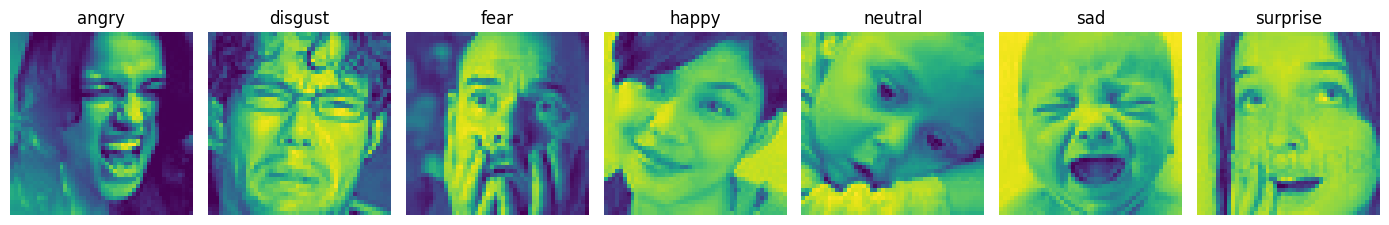

In [ ]:
num_classes: int = len(class_names)

examples = [None] * num_classes

for img_tensor, cls in train_dataset.unbatch():
    idx = int(cls.numpy())
    if examples[idx] is None:
        examples[idx] = img_tensor.numpy()
    if all(e is not None for e in examples):
        break

fig, axes = plt.subplots(1, num_classes, figsize=(14, 3))
for ax, img_arr, cname in zip(axes, examples, class_names):
    ax.imshow(img_arr.astype("uint8"))
    ax.set_title(cname)
    ax.axis("off")

fig.tight_layout()
plt.show()

In [4]:
def plot_class_distribution(dataset_dir, subset_name):
    """Plot the class distribution of the dataset"""
    class_count = {}
    for class_name in os.listdir(dataset_dir):
        class_dir = os.path.join(dataset_dir, class_name)
        num_images = len(os.listdir(class_dir))
        class_count[class_name] = num_images

    plt.figure(figsize=(10, 5))
    plt.bar(class_count.keys(), class_count.values())
    plt.xlabel("Class")
    plt.ylabel("Number of images")
    plt.title("Class distribution" + " " + subset_name)
    plt.show()

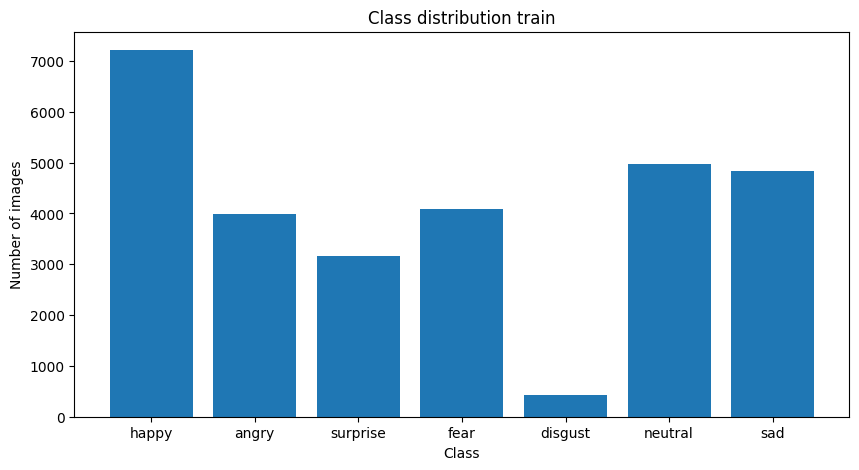

In [5]:
plot_class_distribution(train_dir, "train")

In [35]:
# Print class distribution
class_count = {}
for class_name in os.listdir(train_dir):
    class_dir = os.path.join(train_dir, class_name)
    num_images = len(os.listdir(class_dir))
    class_count[class_name] = num_images

print("Class Distribution:")
for class_name, count in class_count.items():
    print(f"{class_name}: {count}")

Class Distribution:
happy: 7215
angry: 3995
surprise: 3171
fear: 4097
disgust: 436
neutral: 4965
sad: 4830


### Helper Classes and Functions

In [3]:
class DatasetPreparer:
    def __init__(self):
        self.data_augmentation = self._create_augmentation_pipeline()

    def _create_augmentation_pipeline(self):
        """Create the data augmentation pipeline"""
        return keras.Sequential(
            [
                keras.layers.RandomFlip("horizontal"),
                keras.layers.RandomRotation(0.1),
                keras.layers.RandomTranslation(height_factor=0.1, width_factor=0.1),
            ]
        )

    def preprocess_image(self, image, to_gray):
        """Convert image to grayscale float32 and normalize"""
        if to_gray:
            image = tf.image.rgb_to_grayscale(image)

        # Normalize to [0, 1]
        image = tf.image.convert_image_dtype(image, tf.float32) / 255.0

        # Boost contrast
        image = tf.image.adjust_contrast(image, 2.0)
        return image

    def augment_and_preprocess(self, image, augment, to_gray):
        """Apply data augmentation and preprocess the image"""
        if augment:
            image = self.data_augmentation(image)
        return self.preprocess_image(image, to_gray)

    def prepare_dataset(self, dataset, augment=False, to_gray=False):
        """Prepare a single dataset split for training"""
        dataset = dataset.map(
            lambda x, y: (self.augment_and_preprocess(x, augment, to_gray), y),
            num_parallel_calls=tf.data.AUTOTUNE,
        )
        dataset = dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
        return dataset


In [4]:
def plot_history(history) -> None:
    """Function to plot the training and validation history"""
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.plot(history.history["accuracy"], label="accuracy")
    plt.plot(history.history["val_accuracy"], label="val_accuracy")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.title("Training and Validation Accuracy")

    plt.subplot(1, 2, 2)
    plt.plot(history.history["loss"], label="loss")
    plt.plot(history.history["val_loss"], label="val_loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    plt.title("Training and Validation Loss")

    plt.show()


In [5]:
def metrics(model, class_names, test_ds):
    """Function to calculate the metrics of the model"""
    # Evaluate the model
    test_loss, test_accuracy = model.evaluate(test_ds)
    print(f"Loss: {test_loss}")
    print(f"Accuracy: {test_accuracy}")
    print("\n")

    # Make predictions
    predictions = model.predict(test_ds)
    y_pred = np.argmax(predictions, axis=1)

    # Get the true labels
    y_true = np.concatenate([y for x, y in test_ds], axis=0)
    # Check if labels are one-hot or integer before applying argmax
    if y_true.ndim > 1:
        y_true = np.argmax(y_true, axis=1)

    # Print classification report
    from sklearn.metrics import classification_report

    print(classification_report(y_true, y_pred))

    # Generate confusion matrix
    from sklearn.metrics import confusion_matrix

    cm = confusion_matrix(y_true, y_pred)
    cm = pd.DataFrame(cm, index=class_names, columns=class_names)
    plt.figure(figsize=(10, 7))
    sns.heatmap(cm, annot=True, fmt="g", cmap="Blues")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title("Confusion Matrix")
    plt.show()


In [6]:
from sklearn.utils.class_weight import compute_class_weight
from sklearn.preprocessing import MultiLabelBinarizer
from typing import Dict, Any, Union, List


def generate_class_weights(
    class_series: Union[List[Any], np.ndarray],
    multi_class: bool = True,
    one_hot_encoded: bool = False,
) -> Dict[int, float]:
    """
    Generates Keras-compatible class weights.

    - Multi-class: returns weights usable with `class_weight`
    - Multi-label: returns per-class weights (must be converted to sample_weight)
    """

    # -----------------------
    # MULTI-CLASS
    # -----------------------
    if multi_class:
        if one_hot_encoded:
            y = np.argmax(class_series, axis=1)
        else:
            y = np.asarray(class_series)

        # Force integer labels for Keras
        classes, y_int = np.unique(y, return_inverse=True)

        weights = compute_class_weight(
            class_weight="balanced",
            classes=np.arange(len(classes)),
            y=y_int,
        )

        return {int(i): float(w) for i, w in enumerate(weights)}

    # -----------------------
    # MULTI-LABEL
    # -----------------------
    if not one_hot_encoded:
        mlb = MultiLabelBinarizer()
        y = mlb.fit_transform(class_series)
    else:
        y = np.asarray(class_series)

    n_samples, n_classes = y.shape

    # Frequency count
    class_counts = np.array(y).sum(axis=0)

    # Balanced weighting
    weights = np.where(
        class_counts > 0,
        n_samples / (n_classes * class_counts),
        1.0,
    )

    return {int(i): float(w) for i, w in enumerate(weights)}


In [7]:
def plot_train_history(history) -> None:
    # Summarize history for accuracy
    plt.plot(history.history["accuracy"])
    plt.plot(history.history["val_accuracy"])
    plt.title("Model accuracy")
    plt.ylabel("accuracy")
    plt.xlabel("epoch")
    plt.legend(["train", "validation"], loc="upper right")
    plt.show()

    # Summarize history for loss
    plt.plot(history.history["loss"])
    plt.plot(history.history["val_loss"])
    plt.title("Model loss")
    plt.ylabel("loss")
    plt.xlabel("epoch")
    plt.legend(["train", "validation"], loc="upper right")
    plt.show()


### Model Creation

In [ ]:
from keras import layers

@keras.saving.register_keras_serializable()
class RealTimeCNN(keras.Model):
    def __init__(self, num_classes=7, **kwargs):
        super().__init__(**kwargs)

        # Block 1
        self.conv1_1 = layers.Conv2D(64, (3, 3), padding="same", activation="relu")
        self.bn1 = layers.BatchNormalization()
        self.conv1_2 = layers.Conv2D(64, (3, 3), padding="same", activation="relu")
        self.bn2 = layers.BatchNormalization()
        self.pool1 = layers.MaxPooling2D(pool_size=(2, 2))
        self.drop1 = layers.Dropout(0.25)

        # Block 2
        self.conv2_1 = layers.Conv2D(128, (5, 5), padding="same", activation="relu")
        self.bn3 = layers.BatchNormalization()
        self.conv2_2 = layers.Conv2D(128, (5, 5), padding="same", activation="relu")
        self.bn4 = layers.BatchNormalization()
        self.pool2 = layers.MaxPooling2D(pool_size=(2, 2))
        self.drop2 = layers.Dropout(0.25)

        # Block 3
        self.conv3_1 = layers.Conv2D(256, (3, 3), padding="same", activation="relu")
        self.bn5 = layers.BatchNormalization()
        self.conv3_2 = layers.Conv2D(256, (3, 3), padding="same", activation="relu")
        self.bn6 = layers.BatchNormalization()
        self.pool3 = layers.MaxPooling2D(pool_size=(2, 2))
        self.drop3 = layers.Dropout(0.25)

        # Block 4
        self.conv4_1 = layers.Conv2D(512, (3, 3), padding="same", activation="relu")
        self.bn7 = layers.BatchNormalization()
        self.conv4_2 = layers.Conv2D(512, (3, 3), padding="same", activation="relu")
        self.bn8 = layers.BatchNormalization()
        self.pool4 = layers.MaxPooling2D(pool_size=(2, 2))
        self.drop4 = layers.Dropout(0.25)

        self.flatten = layers.Flatten()
        self.dense1 = layers.Dense(1024, activation="relu")
        self.bn9 = layers.BatchNormalization()
        self.drop5 = layers.Dropout(0.5)

        self.dense2 = layers.Dense(512, activation="relu")
        self.bn10 = layers.BatchNormalization()
        self.drop6 = layers.Dropout(0.5)

        self.out = layers.Dense(num_classes, activation="softmax")

    def build(self, input_shape):
        super().build(input_shape)

    def call(self, inputs, training=False):
        x = self.conv1_1(inputs)
        x = self.bn1(x, training=training)
        x = self.conv1_2(x)
        x = self.bn2(x, training=training)
        x = self.pool1(x)
        x = self.drop1(x, training=training)

        x = self.conv2_1(x)
        x = self.bn3(x, training=training)
        x = self.conv2_2(x)
        x = self.bn4(x, training=training)
        x = self.pool2(x)
        x = self.drop2(x, training=training)

        x = self.conv3_1(x)
        x = self.bn5(x, training=training)
        x = self.conv3_2(x)
        x = self.bn6(x, training=training)
        x = self.pool3(x)
        x = self.drop3(x, training=training)

        x = self.conv4_1(x)
        x = self.bn7(x, training=training)
        x = self.conv4_2(x)
        x = self.bn8(x, training=training)
        x = self.pool4(x)
        x = self.drop4(x, training=training)

        x = self.flatten(x)
        x = self.dense1(x)
        x = self.bn9(x, training=training)
        x = self.drop5(x, training=training)

        x = self.dense2(x)
        x = self.bn10(x, training=training)
        x = self.drop6(x, training=training)

        return self.out(x)

    def get_config(self):
        return super().get_config()


model = RealTimeCNN(num_classes=7)
model.build((None, 48, 48, 1))
model.summary()
model.compile(
    optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"]
)

/home/yiannisparask/Projects/emotion-recognition/.venv/lib/python3.10/site-packages/keras/src/layers/layer.py:421: UserWarning: `build()` was called on layer 'real_time_cnn', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


Model: "real_time_cnn"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ ?                      │   0 (unbuilt) │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ ?                      │   0 (unbuilt) │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ ?                      │   0 (unbuilt) │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ ?                      │   0 (unbuilt) │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ ?                      │   0 (unbuilt) │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ ?                      │   0 (unbuilt) │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ ?                      │   0 (unbuilt) │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [9]:
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

my_callbacks = [
    EarlyStopping(monitor="val_loss", patience=15, restore_best_weights=True),
    ReduceLROnPlateau(
        monitor="val_loss", factor=0.2, patience=5, min_lr=1e-5, verbose=1,
    ),
    ModelCheckpoint(
        filepath=f"{cwd}/../model_checkpoints/realtime-cnn.keras",
        monitor="val_loss",
        save_best_only=True,
    ),
]

In [10]:
# Prepare the dataset
dataset_preparer = DatasetPreparer()

train_ds = dataset_preparer.prepare_dataset(train_dataset, augment=True)
validation_ds = dataset_preparer.prepare_dataset(validation_dataset)
test_ds = dataset_preparer.prepare_dataset(test_dataset)

In [11]:
y_train = np.concatenate([y.numpy() for _, y in train_dataset], axis=0)
class_weights = generate_class_weights(
    y_train,
    multi_class=True,
)
print("Class Weights:", class_weights)

Class Weights: {0: 1.0196217703986505, 1: 9.03896103896104, 2: 0.998825831702544, 3: 0.5644491410877098, 4: 0.8275265717888669, 5: 0.8558014755197854, 6: 1.3177280550774526}


2025-12-22 22:25:29.562335: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [12]:
steps_per_epoch = int(tf.data.experimental.cardinality(train_ds).numpy())
validation_steps = int(tf.data.experimental.cardinality(validation_ds).numpy())

history = model.fit(
    train_ds,
    epochs=100,
    validation_data=validation_ds,
    callbacks=my_callbacks,
    class_weight=class_weights,
    steps_per_epoch=steps_per_epoch,
    validation_steps=validation_steps
)

Epoch 1/100


2025-12-22 22:25:41.015894: I external/local_xla/xla/service/service.cc:163] XLA service 0x7fc07c007f60 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2025-12-22 22:25:41.015929: I external/local_xla/xla/service/service.cc:171]   StreamExecutor device (0): NVIDIA GeForce RTX 4060, Compute Capability 8.9
2025-12-22 22:25:41.224743: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2025-12-22 22:25:41.789358: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:473] Loaded cuDNN version 91700
2025-12-22 22:25:43.465690: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_4481', 8956 bytes spill stores, 10196 bytes spill loads

I0000 00:00:1766435156.223498   33877 device_compiler.h:196] Compiled cluster using XLA!  This line is log

179/180 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - accuracy: 0.1532 - loss: 2.8018

2025-12-22 22:26:10.860664: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_4966', 4 bytes spill stores, 4 bytes spill loads

2025-12-22 22:26:11.056636: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_4481', 12 bytes spill stores, 12 bytes spill loads

2025-12-22 22:26:11.170545: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_5240', 16 bytes spill stores, 16 bytes spill loads

2025-12-22 22:26:11.195192: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_4481', 20 bytes spill stores, 20 bytes spill loads

2025-12-22 22:26:11.202500: I external/loc

180/180 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step - accuracy: 0.1533 - loss: 2.8005

2025-12-22 22:26:24.449660: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_310', 8 bytes spill stores, 8 bytes spill loads

2025-12-22 22:26:24.506837: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_321', 8 bytes spill stores, 8 bytes spill loads

2025-12-22 22:26:24.714514: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_321', 60 bytes spill stores, 60 bytes spill loads

2025-12-22 22:26:24.719143: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_310', 60 bytes spill stores, 60 bytes spill loads

2025-12-22 22:26:24.954571: I external/local_xla

180/180 ━━━━━━━━━━━━━━━━━━━━ 50s 175ms/step - accuracy: 0.1597 - loss: 2.5795 - val_accuracy: 0.2376 - val_loss: 2.0490 - learning_rate: 0.0010
Epoch 2/100
180/180 ━━━━━━━━━━━━━━━━━━━━ 11s 60ms/step - accuracy: 0.1683 - loss: 2.2305 - val_accuracy: 0.0141 - val_loss: 2.2073 - learning_rate: 0.0010
Epoch 3/100
180/180 ━━━━━━━━━━━━━━━━━━━━ 14s 80ms/step - accuracy: 0.1807 - loss: 2.0815 - val_accuracy: 0.1744 - val_loss: 1.9449 - learning_rate: 0.0010
Epoch 4/100
180/180 ━━━━━━━━━━━━━━━━━━━━ 10s 58ms/step - accuracy: 0.1988 - loss: 2.0039 - val_accuracy: 0.1974 - val_loss: 1.9891 - learning_rate: 0.0010
Epoch 5/100
180/180 ━━━━━━━━━━━━━━━━━━━━ 11s 61ms/step - accuracy: 0.2156 - loss: 1.9315 - val_accuracy: 0.2075 - val_loss: 1.8700 - learning_rate: 0.0010
Epoch 6/100
180/180 ━━━━━━━━━━━━━━━━━━━━ 14s 80ms/step - accuracy: 0.2221 - loss: 1.8945 - val_accuracy: 0.1630 - val_loss: 2.6903 - learning_rate: 0.0010
Epoch 7/100
180/180 ━━━━━━━━━━━━━━━━━━━━ 11s 61ms/step - accuracy: 0.2700 - loss:

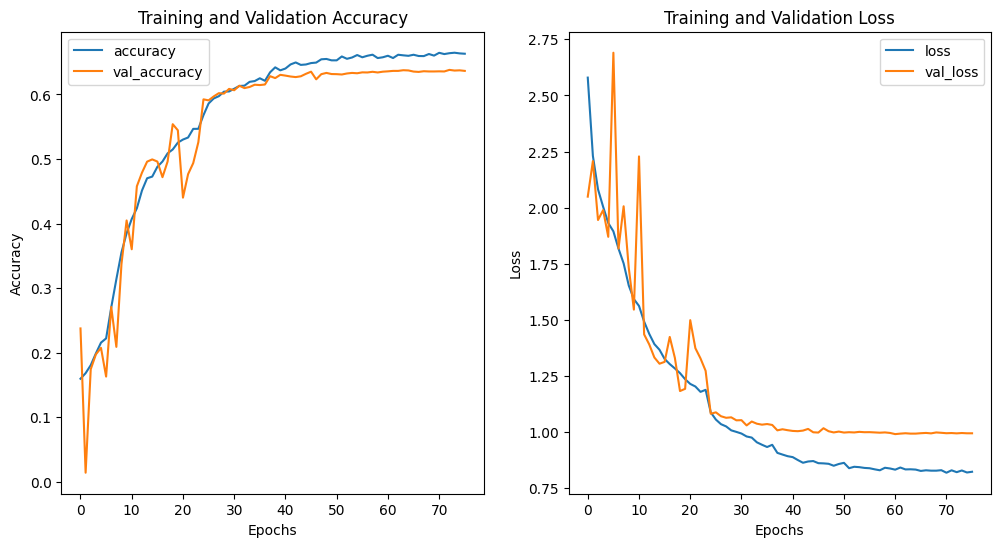

In [13]:
plot_history(history=history)

In [14]:
best_model = RealTimeCNN(num_classes=7)

best_model.build((None, 48, 48, 1))

best_model.load_weights(f"{cwd}/../model_checkpoints/realtime-cnn.keras")

best_model.compile(
    optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"]
)

test_acc, test_loss = best_model.evaluate(test_ds)

print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_acc}")

/home/yiannisparask/Projects/emotion-recognition/.venv/lib/python3.10/site-packages/keras/src/layers/layer.py:421: UserWarning: `build()` was called on layer 'real_time_cnn_1', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


57/57 ━━━━━━━━━━━━━━━━━━━━ 4s 42ms/step - accuracy: 0.1428 - loss: 1.9474
Test Loss: 0.14279744029045105
Test Accuracy: 1.9474470615386963


57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.1428 - loss: 1.9474
Loss: 1.9474470615386963
Accuracy: 0.14279744029045105


57/57 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step
              precision    recall  f1-score   support

           0       1.00      0.00      0.00       958
           1       0.00      0.00      0.00       111
           2       0.14      1.00      0.25      1024
           3       0.00      0.00      0.00      1774
           4       0.00      0.00      0.00      1233
           5       0.00      0.00      0.00      1247
           6       0.00      0.00      0.00       831

    accuracy                           0.14      7178
   macro avg       0.16      0.14      0.04      7178
weighted avg       0.15      0.14      0.04      7178



2025-12-22 22:42:28.093801: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
/home/yiannisparask/Projects/emotion-recognition/.venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/yiannisparask/Projects/emotion-recognition/.venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/yiannisparask/Projects/emotion-recognition/.venv/lib/python3.10/site-packages/sklearn/metrics/_classification.p

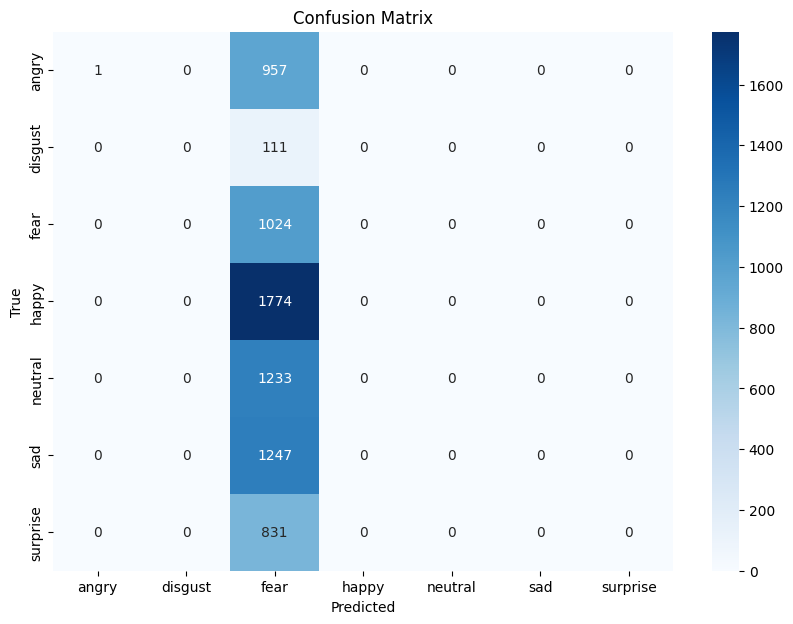

In [15]:
metrics(best_model, class_names, test_ds)
